# Whole brain data processing

In [1]:
import numpy as np
import pandas as pd
import os, sys
from glob import glob
from h5py import File
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import dask.array as da
from cellProcessing import *
import time
import shutil
import dask

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [31]:
dir_root = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20161109/fish2/20161109_2_1_6dpf_GFAP_GC_Huc_RG_GA_CL_fb_OL_f0_0GAIN_20161109_211950/raw'
save_root = '.'

## Preproecssing
This will generate the follow files at `save_root` folder
* `motion_fix_.h5` -- reference image
* `trans_affs.npy` -- affine transform
* `Y_2dnorm_ave.h5` -- average image after detrend
* `local_pca_data.zarr` -- local pca denoised image (This might be used a x4 file size comparing to the raw data), which can be removed afterwards

In [4]:
baseline_percentile = 20
baseline_window = 1000
numCores = 200
preprocessing(dir_root, save_root, numCores=numCores, window=baseline_window, percentile=baseline_percentile)

## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- cell segmentation, which can be removed afterwards

In [ ]:
intensity_percentile = 40
dt = 5 # time downsample
mask_brain(save_root, percentile=intensity_percentile, dt=dt, numCores=20, is_skip_snr=True, save_masked_data=True)

### Check mask

In [35]:
mask = File(f'{save_root}/mask_map.h5', 'r')['default'].value

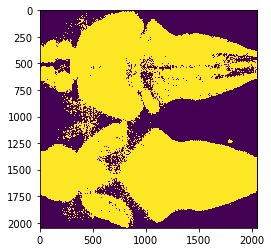

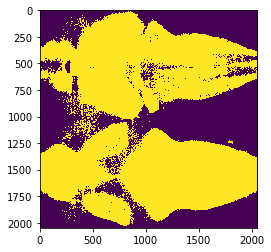

In [38]:
for n_ave_ in mask.squeeze():
    plt.imshow(n_ave_)
    plt.show()

## Demix
This will generate the follow files at `save_root` folder
* `demix_rlt` for each block

In [ ]:
nsplit = 8 # number of split on x and y
demix_cells(save_root, nsplit = nsplit, numCores = 200)

### Check demix results

In [ ]:
block_id = (0, 2, 0, 0)
check_demix_cells(save_root, block_id, nsplit=8, plot_global=True)

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [ ]:
baseline_percentile = 20
baseline_window = 1000
numCores = 200
dff = compute_cell_dff_pixels(dir_root, save_root, 
                              numCores=numCores, 
                              window=baseline_window, 
                              percentile=baseline_percentile)

### df/f on raw cell data

### df/f on denoised cell data